In [1]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt


In [2]:
rel_path = '../trunk_sss/BIN/Debug/'

A_ref = np.loadtxt(f'{rel_path}RESULT0/Inductance_ALIJ.dat', skiprows=1, dtype=float)
PN_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePN.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))
PT_ref = np.loadtxt(f'{rel_path}RESULT0/ProbeVoltagePT.dat', skiprows=1, dtype=float, usecols=np.arange(1, 9))

In [3]:
A = []
PN = []
PT = []
for i in range(1000):
    A.append(np.loadtxt(f"{rel_path}RESULT1/A{i}.dat", skiprows=1, dtype=float))
    PN.append(np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))
    PT.append(np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9)))


In [4]:
Delta_A = np.array([(x - A_ref).reshape(-1) for x in A])
Delta_PN = np.array([(x - PN_ref).reshape(-1) for x in PN])
Delta_PT = np.array([(x - PT_ref).reshape(-1) for x in PT])

In [5]:
# Leave only above diagonal elements
Delta_A = np.array([(x - A_ref) for x in A])
New_delta_A = []
for D_A in Delta_A:
    new = []
    for i in range(12):
        tmp = []
        for j in range(i):
            tmp.append(D_A[i][j])
        if tmp != []:
            for x in tmp:
                new.append(x)

    New_delta_A.append(new)

New_delta_A = np.array(New_delta_A)

In [6]:
Delta_IN = np.concatenate((Delta_PN, Delta_PT), axis=1)

In [7]:
mean_in = Delta_IN.mean()
std_in = Delta_IN.std()
mean_a = New_delta_A.mean()
std_a = New_delta_A.std()

Delta_IN = (Delta_IN-mean_in)/std_in
New_delta_A = (New_delta_A-mean_a)/std_a

In [8]:
New_delta_A.shape, Delta_IN.shape, New_delta_A.mean(), New_delta_A.std()

((1000, 66), (1000, 2576), -1.8328772842902585e-17, 1.0)

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

U_train, U_test, A_train, A_test = train_test_split(Delta_IN, New_delta_A, test_size=0.2)

U_train = torch.from_numpy(U_train).to(dtype=torch.float32).to(device)
U_test = torch.from_numpy(U_test).to(dtype=torch.float32).to(device)
A_train = torch.from_numpy(A_train).to(dtype=torch.float32).to(device)
A_test = torch.from_numpy(np.array(A_test)).to(dtype=torch.float32).to(device)

In [10]:
def compute_loss(A, A_true):
    return torch.sum((A- A_true)**2)

def accuracy(A, A_true):
    acc_min = 1e-2
    return torch.sum(torch.abs(A - A_true) < acc_min)/torch.prod(torch.tensor(A.shape))

def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [17]:
hidden = 100
class Net(nn.Module):
    def __init__(self, device, U_shape, A_shape):
        super(Net, self).__init__()

        self.input_shape = U_shape
        self.output_shape = A_shape
#Number of layers
#1D conv - probably
        self.fcFF = nn.Sequential(
            nn.Linear(self.input_shape, 8*hidden),
            nn.GELU(),
            nn.Linear(8*hidden, 4*hidden),
            nn.GELU(),
            nn.Linear(4*hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, hidden),
            nn.GELU(),
            nn.Linear(hidden, 2*hidden),
            nn.GELU(),
            nn.Linear(2*hidden, 4*hidden),
            nn.GELU(),
            nn.Linear(4*hidden, 8*hidden),
            nn.GELU(),
            nn.Linear(8*hidden, self.output_shape),
            nn.GELU(),
            nn.Linear(self.output_shape, self.output_shape)
        ).to(device)

    def forward(self, U):
        return self.fcFF(U)


In [18]:
net = Net(device, Delta_IN.shape[1], New_delta_A.shape[1])
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, amsgrad=False, weight_decay=0)
net

Net(
  (fcFF): Sequential(
    (0): Linear(in_features=2576, out_features=800, bias=True)
    (1): GELU()
    (2): Linear(in_features=800, out_features=400, bias=True)
    (3): GELU()
    (4): Linear(in_features=400, out_features=200, bias=True)
    (5): GELU()
    (6): Linear(in_features=200, out_features=100, bias=True)
    (7): GELU()
    (8): Linear(in_features=100, out_features=200, bias=True)
    (9): GELU()
    (10): Linear(in_features=200, out_features=400, bias=True)
    (11): GELU()
    (12): Linear(in_features=400, out_features=800, bias=True)
    (13): GELU()
    (14): Linear(in_features=800, out_features=66, bias=True)
    (15): GELU()
    (16): Linear(in_features=66, out_features=66, bias=True)
  )
)

In [214]:
L_train, L_test, acc_train, acc_test = [], [], [], []
L_test = []
batch_size = 100

for epoch in trange(50000):
    net.train(True)
    l = 0.0
    acc = 0.0

    for U_t, A_t in iterate_minibatches(U_train, A_train, batch_size):
        A_h = net.forward(U_t)
        loss = compute_loss(A_h, A_t)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        l += loss.detach().cpu().numpy()
        acc += accuracy(A_h, A_t).cpu().numpy()
            

    L_train.append(l/A_train.shape[0])
    acc_train.append(acc/(1000/batch_size))

    net.train(False)
    A_h = net.forward(U_test)
    with torch.no_grad():
        L = compute_loss(A_h, A_test).cpu().numpy()
    L_test.append(L/A_test.shape[0])
    acc_test.append(accuracy(A_h, A_test).cpu().numpy())

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.plot(L_train, label='train')
ax1.plot(L_test, label='test')
ax1.grid()
ax1.set_title('Loss')
ax1.legend()

ax2.plot(acc_train, label='train')
ax2.plot(acc_test, label='test')
ax2.grid()
ax2.set_title('Accuracy')
ax2.legend()

plt.show()

  0%|          | 248/50000 [00:18<1:01:31, 13.48it/s]


KeyboardInterrupt: 

In [205]:
acc_mean_test = [np.mean(acc_test[i:i+100]) for i in range(0, len(acc_test)-100, 100)]
acc_mean_train = [np.mean(acc_train[i:i+100]) for i in range(0, len(acc_train)-100, 100)]

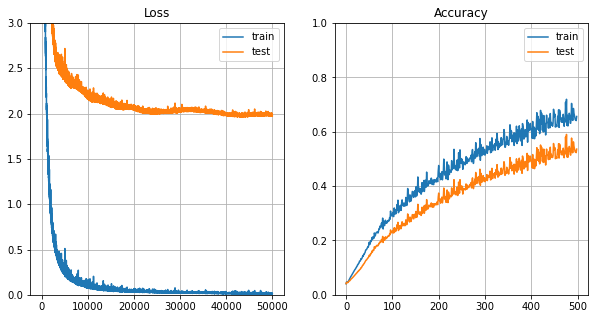

In [207]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10,5))

ax1.plot(L_train, label='train')
ax1.plot(L_test, label='test')
ax1.grid()
ax1.set_ylim(0, 3)
ax1.set_title('Loss')
ax1.legend()

ax2.plot(np.array(acc_mean_train)/0.8, label='train')
ax2.plot(acc_mean_test, label='test')
ax2.grid()
ax2.set_ylim(0, 1)
ax2.set_title('Accuracy')
ax2.legend()


In [21]:
net.load_state_dict(torch.load(r'dump_configurations\50k_86perc.torch'))
net.eval()
accuracy(net(U_train), A_train)

tensor(0.9659, device='cuda:0')

In [104]:
accuracy(net(U_test[0]), A_test[0])

tensor(1., device='cuda:0')

In [106]:
U_test[0]

tensor([ 0.1906, -2.7003,  1.0100,  ..., -0.5573, -0.4478, -1.3010],
       device='cuda:0')

In [140]:
net_pred_A = net(tmp)

In [149]:
i = 10000
net_PN = np.loadtxt(f"{rel_path}RESULT1/PN{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))
net_PT = np.loadtxt(f"{rel_path}RESULT1/PT{i}.dat", skiprows=1, dtype=float, usecols=np.arange(1, 9))


In [110]:
tmp = torch.tensor((np.concatenate((Delta_PN[1], Delta_PT[1])) - mean_in)/std_in).to(dtype=torch.float32).to(device)
tmp_A = torch.tensor(New_delta_A[1]).to(dtype=torch.float32).to(device)

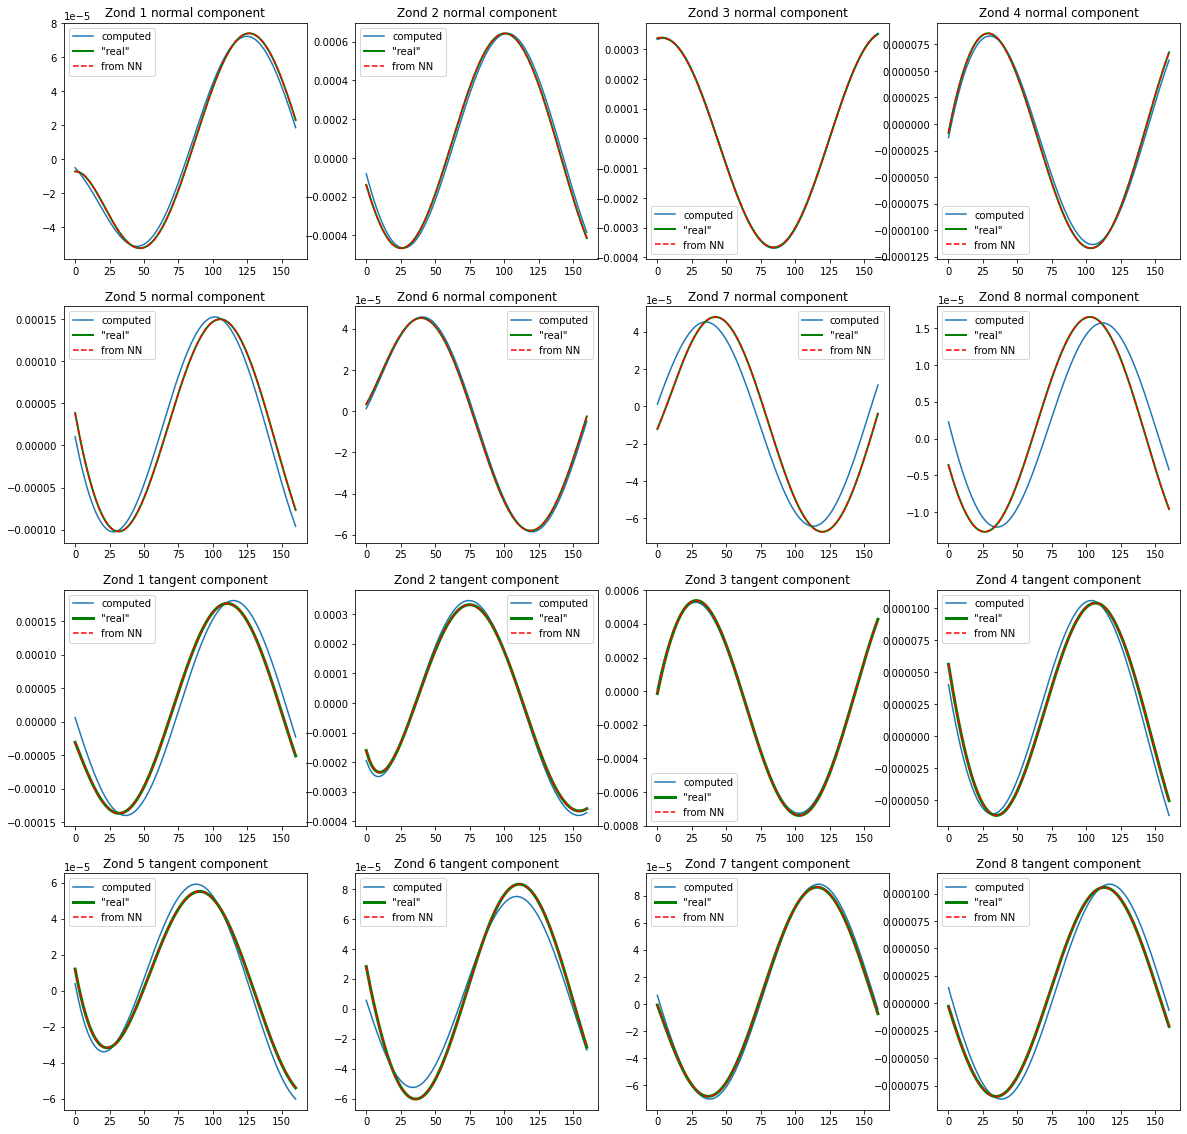

In [156]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20))


for i in range(2):
    for j in range(4):
        ax[i][j].set_title(f'Zond {1+4*i+j} normal component')
        ax[i][j].plot(PN_ref[:, 4*i+j], label='computed')
        ax[i][j].plot(PN[1][:, 4*i+j], 'g', label = '"real"', linewidth=2)
        ax[i][j].plot(net_PN[:, 4*i+j], 'r--', label='from NN')
        ax[i][j].legend()
        
        
        ax[i+2][j].set_title(f'Zond {1+4*i+j} tangent component')
        ax[i+2][j].plot(PT_ref[:, 4*i+j], label='computed')
        ax[i+2][j].plot(PT[1][:, 4*i+j], 'g', label = '"real"', linewidth=3)
        ax[i+2][j].plot(net_PT[:, 4*i+j], 'r--', label='from NN')
        ax[i+2][j].legend()



In [124]:
A_ref

array([[ 5.945658e-01,  2.498980e-01,  2.248834e-01,  3.120895e-01,
         3.591469e-01,  3.293730e-01,  2.277310e-01,  2.498980e-01,
         1.784992e-01,  2.124408e-01,  9.458174e-02,  5.830568e-02],
       [ 2.498980e-01,  2.349870e+00,  1.255353e+00,  6.621551e-01,
         3.586514e-01,  1.571640e-01,  5.282652e-02,  2.440288e-02,
         3.491190e-02,  6.581951e-02, -8.016016e-01, -5.920476e-01],
       [ 2.248834e-01,  1.255353e+00,  3.438256e+00,  1.872342e+00,
         8.179451e-01,  3.340327e-01,  1.092904e-01,  4.769714e-02,
         7.169494e-02,  1.396718e-01, -5.570887e-01, -1.651459e+00],
       [ 3.120895e-01,  6.621551e-01,  1.872342e+00,  5.372239e+00,
         2.868824e+00,  1.006820e+00,  3.154492e-01,  1.326608e-01,
         2.054613e-01,  4.076735e-01, -3.742691e-01, -3.956112e+00],
       [ 3.591469e-01,  3.586514e-01,  8.179451e-01,  2.868824e+00,
         7.670972e+00,  2.658642e+00,  7.291658e-01,  2.910111e-01,
         4.684953e-01,  9.517834e-01, -6.994

In [129]:
Delta_A[1] , New_delta_A[1]*std_a + mean_a

(array([[ 0.0000000e+00,  1.6567800e-02,  2.3540000e-03,  1.0798000e-02,
          9.7648000e-03,  1.3097700e-02,  1.4273200e-02,  1.8319600e-02,
          2.5440000e-04,  3.4031000e-03,  2.7430400e-03,  5.2771700e-03],
        [ 1.6567800e-02,  0.0000000e+00,  1.1566700e-01,  2.4829500e-02,
          1.0680700e-02,  1.3990200e-02,  1.0451800e-03,  1.7277200e-03,
          1.5867900e-03,  6.3386900e-03, -6.1648500e-02, -1.1186200e-02],
        [ 2.3540000e-03,  1.1566700e-01,  0.0000000e+00,  5.9329000e-02,
          4.6400200e-02,  3.3223800e-02,  1.3478000e-03,  3.5640100e-03,
          4.9193300e-03,  1.2916800e-02, -1.1251600e-02, -1.1535500e-01],
        [ 1.0798000e-02,  2.4829500e-02,  5.9329000e-02,  0.0000000e+00,
          2.1840800e-01,  5.0850000e-03,  2.3441900e-02,  1.9166000e-03,
          1.5180000e-03,  1.3695700e-02, -2.2611300e-02, -1.3897800e-01],
        [ 9.7648000e-03,  1.0680700e-02,  4.6400200e-02,  2.1840800e-01,
          0.0000000e+00,  5.1596000e-02,  6.861

In [145]:
_tmp = np.zeros((12, 12))
idx = 0
for i in range(12):
    for j in range(i):
        _tmp[i, j] = net_pred_A[idx]*std_a + mean_a
        _tmp[j, i] = net_pred_A[idx]*std_a + mean_a
        idx += 1

_tmp = A_ref + _tmp
np.savetxt('A.txt', _tmp, fmt='  %11.6e')
_tmp, A[1] 

(array([[ 5.94565800e-01,  2.66367305e-01,  2.27219282e-01,
          3.22867519e-01,  3.68990192e-01,  3.42521524e-01,
          2.42080024e-01,  2.68161664e-01,  1.78802165e-01,
          2.15828385e-01,  9.72575173e-02,  6.36136506e-02],
        [ 2.66367305e-01,  2.34987000e+00,  1.37107630e+00,
          6.87141352e-01,  3.69339385e-01,  1.71162051e-01,
          5.38282114e-02,  2.61077666e-02,  3.64585791e-02,
          7.21213284e-02, -8.63074128e-01, -6.03258405e-01],
        [ 2.27219282e-01,  1.37107630e+00,  3.43825600e+00,
          1.93173535e+00,  8.64329032e-01,  3.67258121e-01,
          1.10645133e-01,  5.12827636e-02,  7.66272635e-02,
          1.52495809e-01, -5.68270004e-01, -1.76670288e+00],
        [ 3.22867519e-01,  6.87141352e-01,  1.93173535e+00,
          5.37223900e+00,  3.08713226e+00,  1.01185092e+00,
          3.38897749e-01,  1.34591177e-01,  2.07057103e-01,
          4.21306345e-01, -3.96878470e-01, -4.09490074e+00],
        [ 3.68990192e-01,  3.6933938

In [132]:
tmp_A, New_delta_A[1]

(tensor([-0.1837, -0.4070,  1.3731, -0.2744, -0.0539,  0.4880, -0.2906, -0.2762,
          0.2849,  2.9870, -0.2382, -0.2242,  0.0779, -0.3641,  0.3665, -0.2198,
         -0.4276, -0.4228, -0.0757,  0.6340,  0.5553, -0.1562, -0.4168, -0.3880,
         -0.4139, -0.4161,  0.3622, -0.2310, -0.4400, -0.4191, -0.3667, -0.4201,
         -0.2954,  0.0568,  0.4189,  0.5015, -0.3905, -0.3444, -0.2411, -0.2288,
          1.0440,  3.4012,  2.6634,  0.0938, -0.2946, -0.4009, -1.4124, -0.6207,
         -0.7992, -0.4440, -0.1022,  0.0063, -0.0325, -0.2821, -0.0969, -0.3611,
         -0.6197, -2.2561, -2.6272, -0.4440,  2.6511,  0.9529, -0.3246,  0.6564,
          1.0256, -0.3797], device='cuda:0'),
 array([-0.18371811, -0.40700677,  1.37305965, -0.27435755, -0.05393269,
         0.48802985, -0.29058838, -0.27620025,  0.28492762,  2.98704749,
        -0.2382309 , -0.22421036,  0.07793578, -0.3641047 ,  0.36654993,
        -0.21976464, -0.4275674 , -0.42281345, -0.0757309 ,  0.63397698,
         0.555